In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import json
import pandas as pd
import transformers
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re

In [3]:
#List of all NDA's in the dataset. 
kes=['nda-11', 'nda-16', 'nda-15', 'nda-10', 'nda-2', 'nda-1', 'nda-19', 'nda-12', 'nda-20', 'nda-3', 'nda-18', 'nda-7', 'nda-17', 'nda-8', 'nda-13', 'nda-5', 'nda-4']

#method to load json file
def get_json(path):  
  #################
  # Opening JSON file
  f = open(path)  
  # returns JSON object as 
  # a dictionary
  data = json.load(f)
  f.close()
  return data

#clean text
def preprocess(sentence):
  sentence=str(sentence)
  sentence = re.sub(r'[^A-Za-z0-9]+', ' ', sentence) 
  sentence = re.sub(r'https?:/\/\S+', ' ', sentence) 
  sentence=sentence.replace('{html}',"") 
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', sentence)
  rem_url=re.sub(r'http\S+', '',cleantext)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_url)  
  return " ".join(tokens)

In [4]:
# Do Not delete
def get_data(data, idx,ke, max_neutral=10):
  dataM=[]
  #Document level
  docid = data['documents'][idx]['id']
  
  string = data['documents'][idx]['text']
  file_name = data['documents'][idx]['file_name']
  spans = data['documents'][idx]['spans']
  spanall=[]
  for span in spans:           
      spanval = string[span[0]: span[1]]
      spanall.append(spanval)
  
  ndas = data['documents'][idx]['annotation_sets'][0]['annotations'] 
  # Keys level
    
  hypothesis = data['labels'][ke]['hypothesis']  

  # Key level   

  choice =ndas[ke] ['choice']
  spansC = ndas[ke] ['spans']    
  for si in range(len(spanall)):
    span_nbr =si
    if si in spansC:
      val=choice
    else:
      val="Neutral"
    premise = spanall[si]
    itm = [docid, file_name , ke, hypothesis, span_nbr, premise,val ]
    dataM.append(itm)
  df = pd.DataFrame(dataM ,columns = ['docid', 'file_name', 'hypotheis_key', 'hypotheis', 'span_nbr', 'premise', 'choice'   ])
  #"[CLS] " and " [SEP] "" [SEP]" 
  df['premise'] = df['premise'].apply(preprocess)
  df['hypotheis']= df['hypotheis'].apply(preprocess) 
  df['label'] = df['choice'].map(lambda s: 0 if s=='Entailment' else (1 if s== 'Contradiction' else 2 ))
  df['entl'] =  df['choice'].map(lambda s : 1 if s== 'Entailment' else 0)
  df['cont'] =  df['choice'].map(lambda s : 1 if s== 'Contradiction' else 0)
  df['neut'] =  df['choice'].map(lambda s : 1 if s== 'Neutral' else 0)

  df1=df[df.choice !='Neutral']
  df2=df[df.choice =='Neutral']
  n = min(max_neutral, len(df2)-1)
  df2= df2.sample(n = n)
  df = pd.concat([df1, df2], sort=False)
  df = df[df.span_nbr !=-1 ][df.premise != ''] [df.hypotheis != '']

  df['bert_sent']= df.apply(lambda s: [s.premise,s.hypotheis], axis=1)
  return df

In [5]:

def create_documents_df(data, kes):
  df = pd.DataFrame([], columns=['docid','file_name','hypotheis_key','hypotheis','span_nbr','premise','choice','label','entl',	'cont','neut','bert_sent'])
  for idx in range(len(data['documents'])):
    for ke in kes:
      ad = get_data(data, idx, ke)
      df = df.append(ad)
  
  return df[["hypotheis","premise","choice"]]

In [6]:
data = get_json('/content/train.json')
dataT = get_json('/content/test.json')

df_train = create_documents_df(data, kes)
df_test = create_documents_df(dataT, kes)

<ipython-input-4-067efda59c9c>:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.span_nbr !=-1 ][df.premise != ''] [df.hypotheis != '']


[Text(0.5, 0, 'Labels')]

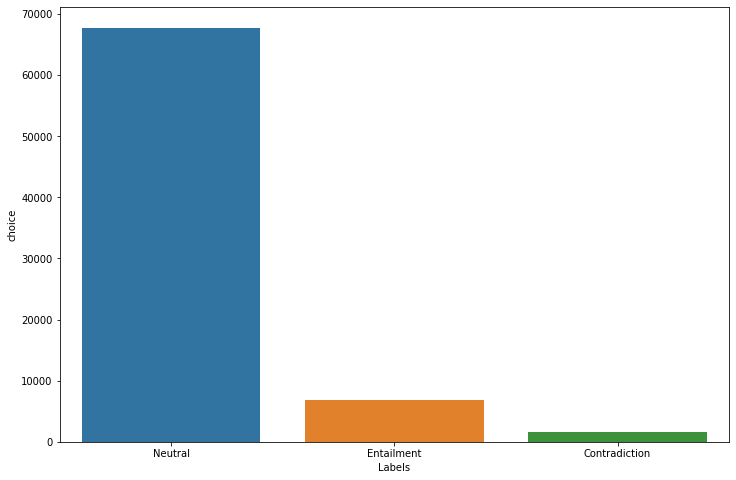

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
 
fig = plt.figure(figsize=(12, 8))

ax = sns.barplot(x=df_train.choice.unique(), y=df_train.choice.value_counts())

ax.set(xlabel='Labels')

In [8]:
df_train.head()

,hypotheis,premise,choice
21,Receiving Party shall not reverse engineer any...,2 3 1,Neutral
9,Receiving Party shall not reverse engineer any...,WHEREAS in connection with RFP 2014 620 Reques...,Neutral
38,Receiving Party shall not reverse engineer any...,4 Nothing in this Agreement is to be construed...,Neutral
39,Receiving Party shall not reverse engineer any...,5 All Confidential Information in any form and...,Neutral
44,Receiving Party shall not reverse engineer any...,8 This Agreement shall enter into force on the...,Neutral


In [9]:
df_train[df_train["premise"] != ""]

,hypotheis,premise,choice
21,Receiving Party shall not reverse engineer any...,2 3 1,Neutral
9,Receiving Party shall not reverse engineer any...,WHEREAS in connection with RFP 2014 620 Reques...,Neutral
38,Receiving Party shall not reverse engineer any...,4 Nothing in this Agreement is to be construed...,Neutral
39,Receiving Party shall not reverse engineer any...,5 All Confidential Information in any form and...,Neutral
44,Receiving Party shall not reverse engineer any...,8 This Agreement shall enter into force on the...,Neutral
...,...,...,...
80,Receiving Party shall not use any Confidential...,Each Party acknowledges that money damages wou...,Neutral
5,Receiving Party shall not use any Confidential...,Each Party in its capacity as a provider of in...,Neutral
81,Receiving Party shall not use any Confidential...,Accordingly each Party will also be entitled t...,Neutral
90,Receiving Party shall not use any Confidential...,12 Confidential Information,Neutral


In [10]:
df_train[df_train["hypotheis"] != ""]

,hypotheis,premise,choice
21,Receiving Party shall not reverse engineer any...,2 3 1,Neutral
9,Receiving Party shall not reverse engineer any...,WHEREAS in connection with RFP 2014 620 Reques...,Neutral
38,Receiving Party shall not reverse engineer any...,4 Nothing in this Agreement is to be construed...,Neutral
39,Receiving Party shall not reverse engineer any...,5 All Confidential Information in any form and...,Neutral
44,Receiving Party shall not reverse engineer any...,8 This Agreement shall enter into force on the...,Neutral
...,...,...,...
80,Receiving Party shall not use any Confidential...,Each Party acknowledges that money damages wou...,Neutral
5,Receiving Party shall not use any Confidential...,Each Party in its capacity as a provider of in...,Neutral
81,Receiving Party shall not use any Confidential...,Accordingly each Party will also be entitled t...,Neutral
90,Receiving Party shall not use any Confidential...,12 Confidential Information,Neutral


In [11]:
df_train[df_train["choice"] != "Neutral"]

,hypotheis,premise,choice
39,Receiving Party shall destroy or return some C...,5 All Confidential Information in any form and...,Entailment
40,Receiving Party shall destroy or return some C...,a if a business relationship is not entered in...,Entailment
38,Agreement shall not grant Receiving Party any ...,4 Nothing in this Agreement is to be construed...,Entailment
51,Receiving Party shall not disclose the fact th...,11 The Recipient shall not advertise or otherw...,Entailment
14,All Confidential Information shall be expressl...,1 Confidential Information whenever used in th...,Entailment
...,...,...,...
105,Receiving Party may share some Confidential In...,i a subsidiary or other affiliate of such Part...,Entailment
106,Receiving Party may share some Confidential In...,ii an officer director employee partner attorn...,Entailment
9,Receiving Party shall not use any Confidential...,Neither the Recipient nor any of the Recipient...,Entailment
10,Receiving Party shall not use any Confidential...,a make use of any of the Provider s Confidenti...,Entailment


In [12]:
df_train[df_train["choice"] != "Neutral"]

,hypotheis,premise,choice
39,Receiving Party shall destroy or return some C...,5 All Confidential Information in any form and...,Entailment
40,Receiving Party shall destroy or return some C...,a if a business relationship is not entered in...,Entailment
38,Agreement shall not grant Receiving Party any ...,4 Nothing in this Agreement is to be construed...,Entailment
51,Receiving Party shall not disclose the fact th...,11 The Recipient shall not advertise or otherw...,Entailment
14,All Confidential Information shall be expressl...,1 Confidential Information whenever used in th...,Entailment
...,...,...,...
105,Receiving Party may share some Confidential In...,i a subsidiary or other affiliate of such Part...,Entailment
106,Receiving Party may share some Confidential In...,ii an officer director employee partner attorn...,Entailment
9,Receiving Party shall not use any Confidential...,Neither the Recipient nor any of the Recipient...,Entailment
10,Receiving Party shall not use any Confidential...,a make use of any of the Provider s Confidenti...,Entailment


In [13]:
df_train.to_csv(r'/content/train.csv', index=False)
df_test.to_csv(r'/content/test.csv', index=False)